In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-for-ocr/ocr_a_reference.png
/kaggle/input/test-for-ocr/credit_card_04.png
/kaggle/input/test-for-ocr/credit_card_02.png
/kaggle/input/test-for-ocr/test.jpg
/kaggle/input/test-for-ocr/credit_card_05.png
/kaggle/input/test-for-ocr/credit_card_01.png
/kaggle/input/test-for-ocr/credit_card_03.png


In [2]:
cd /kaggle/input/test-for-ocr

/kaggle/input/test-for-ocr


In [3]:
ls


credit_card_01.png  credit_card_03.png  credit_card_05.png   test.jpg
credit_card_02.png  credit_card_04.png  ocr_a_reference.png


In [6]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=e95ed21a6a896e30cb85a1987efeeea140f3bef1e0c503f569442cd51f2163ef
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [7]:
from imutils import contours
import numpy as np

import argparse
import imutils
import cv2
from matplotlib import pyplot as plt

In [8]:
FIRST_NUMBER = {
    "3": "American Express",
    "4": "Visa",
    "5": "MasterCard",
    "6": "Discover Card"
}

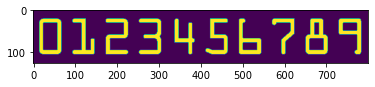

In [9]:
ref = cv2.imread('ocr_a_reference.png')
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(ref)

In [10]:
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
digits = {}

In [11]:
for (i, c) in enumerate(refCnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))

    # update the digits dictionary, mapping the digit name to the ROI
    digits[i] = roi

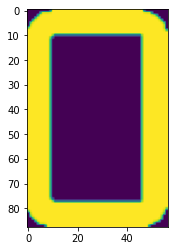

In [12]:
plt.imshow(digits[0])

In [13]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

In [14]:
image = cv2.imread('credit_card_05.png')
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

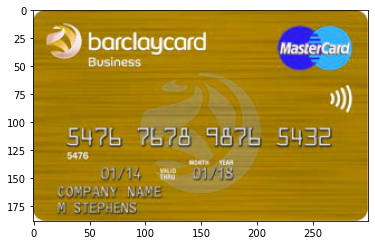

In [15]:
plt.imshow(image)

In [16]:
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

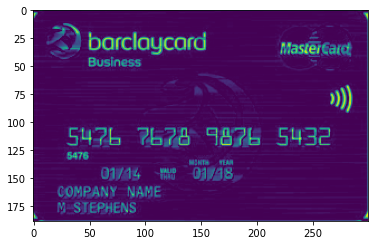

In [17]:
plt.imshow(tophat)

In [18]:
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

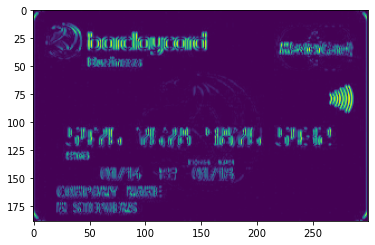

In [19]:
plt.imshow(gradX)

In [20]:
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]


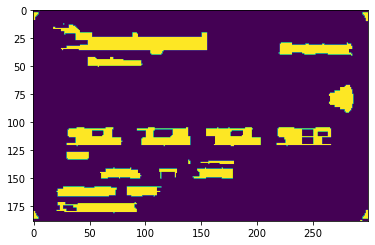

In [21]:
plt.imshow(thresh)

In [22]:
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

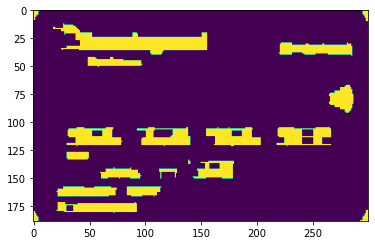

In [23]:
plt.imshow(thresh)

In [24]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []


In [25]:
# loop over the contours
for (i, c) in enumerate(cnts):
	# compute the bounding box of the contour, then use the
	# bounding box coordinates to derive the aspect ratio
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)

	# since credit cards used a fixed size fonts with 4 groups
	# of 4 digits, we can prune potential contours based on the
	# aspect ratio
	if ar > 2.5 and ar < 4.0:
		# contours can further be pruned on minimum/maximum width
		# and height
		if (w > 40 and w < 55) and (h > 10 and h < 20):
			# append the bounding box region of the digits group
			# to our locations list
			locs.append((x, y, w, h))

# sort the digit locations from left-to-right, then initialize the
# list of classified digits
locs = sorted(locs, key=lambda x:x[0])
output = []

In [26]:

# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
	# initialize the list of group digits
	groupOutput = []

	# extract the group ROI of 4 digits from the grayscale image,
	# then apply thresholding to segment the digits from the
	# background of the credit card
	group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
	group = cv2.threshold(group, 0, 255,
		cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

	# detect the contours of each individual digit in the group,
	# then sort the digit contours from left to right
	digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	digitCnts = imutils.grab_contours(digitCnts)
	digitCnts = contours.sort_contours(digitCnts,
		method="left-to-right")[0]

	# loop over the digit contours
	for c in digitCnts:
		# compute the bounding box of the individual digit, extract
		# the digit, and resize it to have the same fixed size as
		# the reference OCR-A images
		(x, y, w, h) = cv2.boundingRect(c)
		roi = group[y:y + h, x:x + w]
		roi = cv2.resize(roi, (57, 88))

		# initialize a list of template matching scores
		scores = []

		# loop over the reference digit name and digit ROI
		for (digit, digitROI) in digits.items():
			# apply correlation-based template matching, take the
			# score, and update the scores list
			result = cv2.matchTemplate(roi, digitROI,
				cv2.TM_CCOEFF)
			(_, score, _, _) = cv2.minMaxLoc(result)
			scores.append(score)

		# the classification for the digit ROI will be the reference
		# digit name with the *largest* template matching score
		groupOutput.append(str(np.argmax(scores)))

	# draw the digit classifications around the group
	cv2.rectangle(image, (gX - 5, gY - 5),
		(gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
	cv2.putText(image, "".join(groupOutput), (gX, gY - 15),
		cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

	# update the output digits list
	output.extend(groupOutput)

Credit Card Type: MasterCard
Credit Card #: 5476767898765432


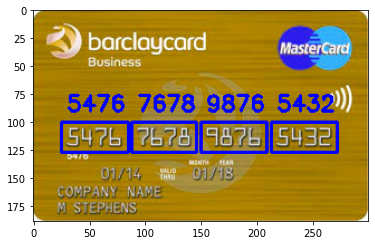

In [27]:
# display the output credit card information to the screen
print("Credit Card Type: {}".format(FIRST_NUMBER[output[0]]))
print("Credit Card #: {}".format("".join(output)))
plt.imshow(image)
